#**Background**

In late January 2021, GameStop (GME), a video game retailer, became the center of a financial phenomenon known as a 'short squeeze.' This occurred when a surge of retail investors, coordinating through social media platforms like Reddit's r/wallstreetbets, began buying up GameStop's stock. This drove up the stock price dramatically, which in turn inflicted heavy losses on hedge funds and other investors who had bet against the stock by short-selling it. The event drew widespread media attention, sparked controversy over stock market practices, and led to hearings in the U.S. Congress.

#**Instructions**

## **Part 1: Model Building (30%)**

- **Data Acquisition**: Select relevant historical data for GameStop (stock prices, trading volume, financial ratios) over the past year. Gather social media sentiment data from Twitter and Reddit platforms, focusing on discussions related to GameStop during the chosen period.
- **Feature Engineering**: Preprocess and transform the historical data and social media sentiment data into features suitable for modeling. Explore text analysis techniques to quantify sentiment from Reddit and Twitter data.
- **Model Building**: Build the following models:
    - ***Time-series forecasting***: This model will focus on historical stock price data, employing neural network architectures like LSTMs or other RNN-based architectures to capture sequential patterns and long-term dependencies.
    - ***Sentiment analysis***: This model will leverage social media data related to GameStop, utilizing text analysis techniques like sentiment lexicons, topic modeling, or word embeddings to quantify sentiment scores and extract relevant features.
    - ***Model fusion***: This model will combine the predictions from both the time-series forecasting and sentiment analysis to perform the final predictions.

## **Part 2: Retrospective Predictions and Evaluation (20%)**

- **Prediction Period**: Apply the chosen model to predict GameStop's closing prices for the months of December 2020, January 2021, and February 2021.
- **Evaluation**: Compare the predicted prices with the actual closing prices for each month. Calculate evaluation metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE) to assess the model's accuracy.
- **Visualization**: Analyze and visualize the discrepancies between predicted and actual prices, identifying periods of significant deviations and potential reasons for these differences.

## **Part 3: GameStop Short Squeeze and Model Adaptation (30%)**

- **Event Analysis**: Explore the social media landscape surrounding the GameStop short squeeze in January 2021. Analyze the volume, sentiment, and key themes of discussions on platforms like Reddit's r/WallStreetBets to understand the event's dynamics.
- **Model Sensitivity**: Investigate how the model's performance would change if exposed to data with similar characteristics to the GameStop short squeeze (e.g., sudden shifts in sentiment, high volatility). Conduct sensitivity analysis by injecting simulated spikes in social media sentiment and observing the model's predictions.
- **Algorithmic Adjustments**: Based on the event analysis and sensitivity analysis, propose concrete modifications to the existing model or feature engineering processes to improve its performance in capturing the impact of extreme social media sentiment on stock prices.

## **Part 4: Conclusion and Future Directions (20%)**

- **Summarize**: Briefly present the key findings of the assignment, including the model's accuracy, limitations, and sensitivity to social media events.
- **Discuss**: Analyze the impact of the GameStop short squeeze on the effectiveness of traditional forecasting models and the value of incorporating social media sentiment data. Comment on the ethics of social media mining.
- **Propose**: Suggest future research directions to improve the performance of stock price prediction models that integrate social media sentiment, considering potential challenges and ethical considerations.


#**Sources**

- **Financial News Websites**: Students can scrape financial news articles from websites like Bloomberg, Reuters, CNBC, and The Wall Street Journal using web scraping techniques.

- **Kaggle Sentiment Analysis for Financial News Dataset**: This dataset contains the sentiments for financial news headlines from the perspective of a retail investor. https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-newsLinks to an external site.

- **Reddit**:  Utilize the Pushshift API (https://github.com/pushshift/api) to access historical and real-time Reddit data for mentions of GameStop, particularly within the r/WallStreetBets subreddit.

- **StockTwits**: Utilize the StockTwits API (https://stocktwits.com/Links to an external site. ) to track sentiment towards GameStop through hashtags and user mentions. Analyze the language used by traders and investors to gauge their confidence, fear, and overall sentiment towards the stock.

# Important Info

- **Prediction Period**:    2020-12-01 to 2021-03-01
- **Re-evaluation Period**: 2021-01-01 to 2021-02-01
- **Evaluation Metrics**:   MSE, RMSE, MAE

I think you can go back as far as you want with the data for training.

#**Libraries**

In [3]:
!pip install yfinance --upgrade --no-cache-dir -q

In [4]:
!pip install chardet -q

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import json, yaml
import chardet
import requests

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [6]:
plt.rcParams["font.family"] = "monospace"

In [7]:
START_DATE  = '2021-01-01'
END_DATE    = '2022-01-01'
ALL_DATES   = pd.date_range(start=START_DATE, end=END_DATE, freq='D').tz_localize('America/New_York')
ALL_DATES

DatetimeIndex(['2021-01-01 00:00:00-05:00', '2021-01-02 00:00:00-05:00',
               '2021-01-03 00:00:00-05:00', '2021-01-04 00:00:00-05:00',
               '2021-01-05 00:00:00-05:00', '2021-01-06 00:00:00-05:00',
               '2021-01-07 00:00:00-05:00', '2021-01-08 00:00:00-05:00',
               '2021-01-09 00:00:00-05:00', '2021-01-10 00:00:00-05:00',
               ...
               '2021-12-23 00:00:00-05:00', '2021-12-24 00:00:00-05:00',
               '2021-12-25 00:00:00-05:00', '2021-12-26 00:00:00-05:00',
               '2021-12-27 00:00:00-05:00', '2021-12-28 00:00:00-05:00',
               '2021-12-29 00:00:00-05:00', '2021-12-30 00:00:00-05:00',
               '2021-12-31 00:00:00-05:00', '2022-01-01 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', length=366, freq=None)

#**Mount Drive and API Keys**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
DATA_DIR = '/content/drive/MyDrive/NLX/ind-assignment/data'
FIG_DIR = '/content/drive/MyDrive/NLX/ind-assignment/figs'


In [10]:
try:
    with open("/content/drive/MyDrive/NLX/api-keys.yml") as file:
        api_keys = yaml.safe_load(file)

        print('API Keys...')

        KAGGLE_USER     = api_keys['kaggle']['username']
        KAGGLE_KEY      = api_keys['kaggle']['key']
        WANDB_KEY       = api_keys['wandb']['personal-key']
        DATAVERSE_KEY   = api_keys['harvard-dataverse']['key']

        print(f"Kaggle Username:    {KAGGLE_USER}")
        print(f"Kaggle Key:         {KAGGLE_KEY}")
        print(f"WandB Personal Key: {WANDB_KEY}")
        print(f"Dataverse Key:      {DATAVERSE_KEY}")

except:
    print('API keys not available...')

API Keys...
Kaggle Username:    qauster
Kaggle Key:         744800ea4111856fccdabf1981b9e501
WandB Personal Key: b9e7bcaa9db8164ef425369737564055b2108515
Dataverse Key:      e713c819-72d9-4aca-8dc0-c1389bec550d


#**Yahoo Finance**

In [ ]:
gme_left = pd.MultiIndex.from_product([ALL_DATES], names=['date']).to_frame(index=False)
print(gme_left.info())
gme_left.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype                           
---  ------  --------------  -----                           
 0   date    366 non-null    datetime64[ns, America/New_York]
dtypes: datetime64[ns, America/New_York](1)
memory usage: 3.0 KB
None


,date
0,2021-01-01 00:00:00-05:00
1,2021-01-02 00:00:00-05:00
2,2021-01-03 00:00:00-05:00
3,2021-01-04 00:00:00-05:00
4,2021-01-05 00:00:00-05:00


In [ ]:
ticker = yf.Ticker('GME')

gme_hist = ticker.history(start=START_DATE, end=END_DATE)
print(gme_hist.shape)

gme_hist = gme_hist.reset_index()
gme_hist.columns = gme_hist.columns.str.lower()

gme_hist['date'] = pd.to_datetime(gme_hist['date'])

gme_hist.head()

(252, 7)


,date,open,high,low,close,volume,dividends,stock splits
0,2021-01-04 00:00:00-05:00,4.7500,4.7750,4.2875,4.3125,40090000,0.0,0.0
1,2021-01-05 00:00:00-05:00,4.3375,4.5200,4.3075,4.3425,19846000,0.0,0.0
2,2021-01-06 00:00:00-05:00,4.3350,4.7450,4.3325,4.5900,24224800,0.0,0.0
3,2021-01-07 00:00:00-05:00,4.6175,4.8625,4.5050,4.5200,24517200,0.0,0.0
4,2021-01-08 00:00:00-05:00,4.5450,4.5750,4.2700,4.4225,25928000,0.0,0.0


In [ ]:
gme = gme_left.merge(gme_hist, on=['date'], how='left')
gme = gme.fillna(method='ffill')
gme = gme.dropna()
print(gme.shape)
gme.head()

(363, 8)


,date,open,high,low,close,volume,dividends,stock splits
3,2021-01-04 00:00:00-05:00,4.7500,4.7750,4.2875,4.3125,40090000.0,0.0,0.0
4,2021-01-05 00:00:00-05:00,4.3375,4.5200,4.3075,4.3425,19846000.0,0.0,0.0
5,2021-01-06 00:00:00-05:00,4.3350,4.7450,4.3325,4.5900,24224800.0,0.0,0.0
6,2021-01-07 00:00:00-05:00,4.6175,4.8625,4.5050,4.5200,24517200.0,0.0,0.0
7,2021-01-08 00:00:00-05:00,4.5450,4.5750,4.2700,4.4225,25928000.0,0.0,0.0


In [ ]:
gme.to_csv(os.path.join(DATA_DIR, 'gme.csv'), encoding='utf-8', index=False)

#**Kaggle**

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    kaggle_credentials = {"username": KAGGLE_USER, "key": KAGGLE_KEY}
    f.write(json.dumps(kaggle_credentials))

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=165259d56fc2cb80b8170b6be38e3085042be78e263777f5f138531d8dd145d0
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
!mkdir data
!kaggle datasets download -d ankurzing/sentiment-analysis-for-financial-news
!unzip -qo /content/sentiment-analysis-for-financial-news.zip -d '/content/data'

  0% 0.00/903k [00:00<?, ?B/s]
100% 903k/903k [00:00<00:00, 90.6MB/s]


In [ ]:
rawdata = open('/content/data/all-data.csv', "rb").read()
chardet.detect(rawdata)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}

In [ ]:
kaggle_data = pd.read_csv('/content/data/all-data.csv', header=None, encoding='Windows-1252')
kaggle_data.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
kaggle_data.columns = ['label', 'text']
kaggle_data.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
kaggle_data.to_csv(os.path.join(DATA_DIR, 'kaggle.csv'), encoding='utf-8', index=False)

#**Financial Websites**

##***Bloomberg***

##***Reuters***

#**Reddit**

In [ ]:
!kaggle datasets download -d thedevastator/gamestop-inc-stock-prices-and-social-media-senti
!unzip -qo /content/gamestop-inc-stock-prices-and-social-media-senti.zip -d '/content/data'

 97% 173M/178M [00:02<00:00, 82.7MB/s]
100% 178M/178M [00:02<00:00, 64.4MB/s]


In [ ]:
reddit_comments = pd.read_csv('/content/data/six-months-of-gme-on-reddit-comments.csv', low_memory=False)
reddit_posts    = pd.read_csv('/content/data/six-months-of-gme-on-reddit-posts.csv', low_memory=False)

In [ ]:
reddit_comments.head()

,index,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,0,comment,hitrmcd,43zwn1,superstonk,False,1.635725e+09,https://old.reddit.com/r/Superstonk/comments/q...,u/all_hail_to_me or he’s trying to say\nMake G...,0.6588,2.0
1,1,comment,hitrm85,43zwn1,superstonk,False,1.635725e+09,https://old.reddit.com/r/Superstonk/comments/q...,That also confirmed it for me. I was hesitant ...,0.6249,2.0
2,2,comment,hitrghb,43zwn1,superstonk,False,1.635725e+09,https://old.reddit.com/r/Superstonk/comments/q...,What if RC intentionally chose GME as his targ...,0.9315,1.0
3,3,comment,hitrg5l,2u6vg,gme,False,1.635725e+09,https://old.reddit.com/r/GME/comments/qjsffk/r...,"Definitely retarded, but 30 million could do t...",-0.4310,2.0
4,4,comment,hitre4y,36vxjo,churchofcovid,False,1.635725e+09,https://old.reddit.com/r/ChurchOfCOVID/comment...,Damn for a second I thought this was about the...,-0.4019,1.0


In [ ]:
reddit_posts.head()

,index,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,0,post,qk1h8a,vbkcx,torontology,False,1635723231,https://old.reddit.com/r/Torontology/comments/...,v.redd.it,https://v.redd.it/7dh3i7gdfvw71,NaN,Buck X TP (ErrCity/GMG/GME/Empringham) - Empri...,1
1,1,post,qk1g01,43zwn1,superstonk,False,1635723116,https://old.reddit.com/r/Superstonk/comments/q...,i.redd.it,https://i.redd.it/qca2bpxwevw71.jpg,NaN,"GME Game Plan, Just Everyday Free Market Compe...",46
2,2,post,qk14tt,3tw06h,u_omsc196003250013r,False,1635722055,https://old.reddit.com/r/u_Omsc196003250013R/c...,youtube.com,https://youtube.com/watch?v=mqOSkLywtIk&amp;fe...,NaN,AMC Stock &amp; GME Stock - This Week Could Ge...,1
3,3,post,qk14jh,43zwn1,superstonk,False,1635722029,https://old.reddit.com/r/Superstonk/comments/q...,i.redd.it,https://i.redd.it/effwjrgvbvw71.jpg,NaN,It’s not much but every bit counts for Q3! Bri...,110
4,4,post,qk135i,43zwn1,superstonk,False,1635721895,https://old.reddit.com/r/Superstonk/comments/q...,i.redd.it,https://i.redd.it/ptm9q6chbvw71.jpg,NaN,A wild zen ape holding GME 🦍🤝🦍,20


In [ ]:
reddit_comments.to_csv(os.path.join(DATA_DIR, 'reddit_comments.csv'), encoding='utf-8', index=False)

#**RedditLarge**

In [11]:
reddit_harvard = pd.read_csv(os.path.join(DATA_DIR, 'rGME_dataset_features.csv'))
print(reddit_harvard.shape)
reddit_harvard.head()

<ipython-input-11-263cd5cad90b>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_harvard = pd.read_csv(os.path.join(DATA_DIR, 'rGME_dataset_features.csv'))


(1033236, 74)


,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,...,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,...,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,...,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,...,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,...,0,0,0,1,0,0,0,0,0,0


In [12]:
reddit_harvard.columns

Index(['Unnamed: 0', 'id', 'title', 'url', 'score', 'author', 'num_comments',
       'date', 'flair', 'compound', 'neg', 'neu', 'pos', 'spacy_title',
       'clean_text', 'char_count', 'word_count', 'word_count_cln',
       'stopword_count', 'pos_tags', 'dep_tags', '_NOUN', '_VERB', '_ADP',
       '_ADJ', '_DET', '_PROPN', '_INTJ', '_PUNCT', '_NUM', '_PRON', '_ADV',
       '_PART', '_amod', '_ROOT', '_punct', '_advmod', '_auxpass',
       '_nsubjpass', '_ccomp', '_acomp', '_neg', '_nsubj', '_aux', '_agent',
       '_det', '_pobj', '_prep', '_csubj', '_nummod', '_attr', '_acl',
       '_relcl', '_dobj', '_pcomp', '_xcomp', '_cc', '_conj', '_mark', '_prt',
       '_compound', '_dep', '_advcl', '_parataxis', '_poss', '_intj', '_appos',
       '_npadvmod', '_predet', '_case', '_expl', '_oprd', '_dative', '_nmod'],
      dtype='object')

In [31]:
cols = [
    'id',
    'title',
    'date',
    'flair',
    'compound',
    'neg',
    'neu',
    'pos'
]

reddit_harvard.loc[:10, cols]

,id,title,date,flair,compound,neg,neu,pos
0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,2021-01-04,NaN,0.9872,0.000,0.189,0.811
1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,2021-01-04,NaN,0.9906,0.000,0.079,0.921
2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,2021-01-05,NaN,0.5319,0.000,0.744,0.256
3,krcwch,You already know what we must do brothers and ...,2021-01-05,NaN,-0.2960,0.115,0.885,0.000
4,krnthg,ICR conference (11th Jan),2021-01-06,NaN,0.0000,0.000,1.000,0.000
5,kryizd,Hey guys! We have a free discord channel that'...,2021-01-06,NaN,0.7777,0.107,0.516,0.377
6,kuo3w1,"GME is FINALLY going to the moon, this technic...",2021-01-10,NaN,0.9667,0.000,0.392,0.608
7,kv1t51,Ryan Cohen appointed to board!!!!?,2021-01-11,NaN,0.0000,0.000,1.000,0.000
8,kv1w9e,"Holly f*ck, our GME rollercoaster will break o...",2021-01-11,NaN,0.0000,0.000,1.000,0.000
9,kv3vrm,BUCKLE YOUR SEATBELTS OR YOURE GONNA FALL OFF ...,2021-01-11,NaN,0.9517,0.000,0.423,0.577


In [14]:
print(reddit_harvard['date'].min())
print(reddit_harvard['date'].max())

2021-01-04
2021-12-31


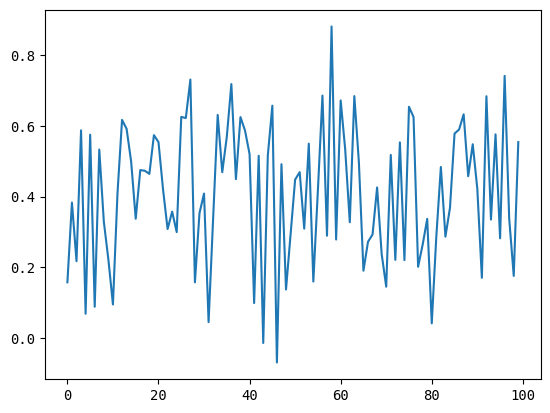

In [19]:
plt.plot(np.random.normal(0.4, 0.2, 100))

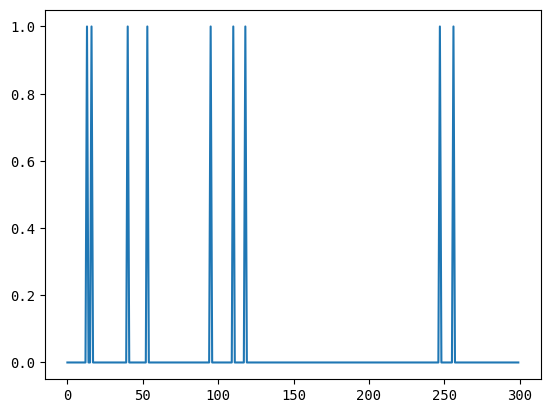

In [22]:
plt.plot(np.random.binomial(1, 0.02, 300))

In [59]:
# Add systematic synthetic noise to compound

len_reddit = reddit_harvard.shape[0]

mu, sigma = 0.4, 0.2

np.random.seed(1)

reddit_harvard['compound_synth_pos'] = reddit_harvard['compound'] + np.random.normal(mu, sigma, len_reddit)
# reddit_harvard['compound_synth_neg'] = reddit_harvard['compound'] - np.random.normal(mu, sigma, len_reddit)
reddit_harvard['compound_synth_bin'] = reddit_harvard['compound'] + np.random.binomial(1, 0.0001, len_reddit)*10000


In [60]:
# Aggregate daily sentiment (mean, sum, count)
reddit_agg = reddit_harvard.groupby('date', as_index=False)[
    ['compound', 'compound_synth_pos', 'compound_synth_bin', 'neg', 'neu', 'pos']
    ]\
    .agg(['count', 'mean', 'sum'])

# Flatten columns to be 1d
reddit_agg.columns = ['_'.join(col) for col in reddit_agg.columns]

# Reset index
reddit_agg = reddit_agg.reset_index()

# Localize timeseries
reddit_agg['date'] = pd.to_datetime(reddit_agg['date']).dt.tz_localize('America/New_York')
print(reddit_agg.shape)

# Rename and drop some cols
reddit_agg = reddit_agg.rename(columns={'neg_count': 'count'})
reddit_agg['log_count'] = np.log(reddit_agg['count'] + 1e-1)
reddit_agg = reddit_agg.drop(columns=['count', 'compound_count', 'neu_count', 'pos_count'])

# Create log variables for better ability to interpret variation
# (otherwise some time periods get washed out)
# The 1e-1 addition is for numerical stability
reddit_agg['log_compound_sum'] = np.log(reddit_agg['compound_sum'] + 1e-1)
reddit_agg['log_compound_synth_pos_sum'] = np.log(reddit_agg['compound_synth_pos_sum'] + 1e-1)
reddit_agg['log_compound_synth_bin_sum'] = np.log(reddit_agg['compound_synth_bin_sum'] + 1e-1)
reddit_agg['log_neg_sum'] = np.log(reddit_agg['neg_sum'] + 1e-1)
reddit_agg['log_neu_sum'] = np.log(reddit_agg['neu_sum'] + 1e-1)
reddit_agg['log_pos_sum'] = np.log(reddit_agg['pos_sum'] + 1e-1)

# reddit_agg.filter(regex='log_').replace([np.inf, -np.inf], np.nan).interpolate(inplace=True)

reddit_agg.tail()

(343, 19)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,date,compound_mean,compound_sum,compound_synth_pos_count,compound_synth_pos_mean,compound_synth_pos_sum,compound_synth_bin_count,compound_synth_bin_mean,compound_synth_bin_sum,neg_mean,...,neu_sum,pos_mean,pos_sum,log_count,log_compound_sum,log_compound_synth_pos_sum,log_compound_synth_bin_sum,log_neg_sum,log_neu_sum,log_pos_sum
338,2021-12-27 00:00:00-05:00,0.142411,18.7983,132,0.550141,72.618676,132,0.142411,18.7983,0.045379,...,109.473,0.125295,16.539,4.883559,2.939072,4.286598,2.939072,1.806648,4.696591,2.811749
339,2021-12-28 00:00:00-05:00,0.192014,35.7146,186,0.587417,109.259619,186,0.192014,35.7146,0.035344,...,156.184,0.124962,23.243,5.226284,3.578356,4.694642,3.578356,1.898219,5.051675,3.150297
340,2021-12-29 00:00:00-05:00,0.142930,26.7279,187,0.537546,100.521085,187,0.142930,26.7279,0.042465,...,157.171,0.117032,21.885,5.231643,3.289442,4.611362,3.289442,2.084553,5.057970,3.090360
341,2021-12-30 00:00:00-05:00,0.169785,30.5613,180,0.570232,102.641709,180,0.169785,30.5613,0.040272,...,149.323,0.130167,23.430,5.193512,3.423001,4.632218,3.423001,1.994564,5.006781,3.158276
342,2021-12-31 00:00:00-05:00,0.169292,24.3781,144,0.579859,83.499745,144,0.169292,24.3781,0.040049,...,119.610,0.129340,18.625,4.970508,3.197779,4.426040,3.197779,1.769343,4.785072,2.929860


In [62]:
# Save data
reddit_agg.to_csv(os.path.join(DATA_DIR, 'reddit.csv'), encoding='utf-8', index=False)

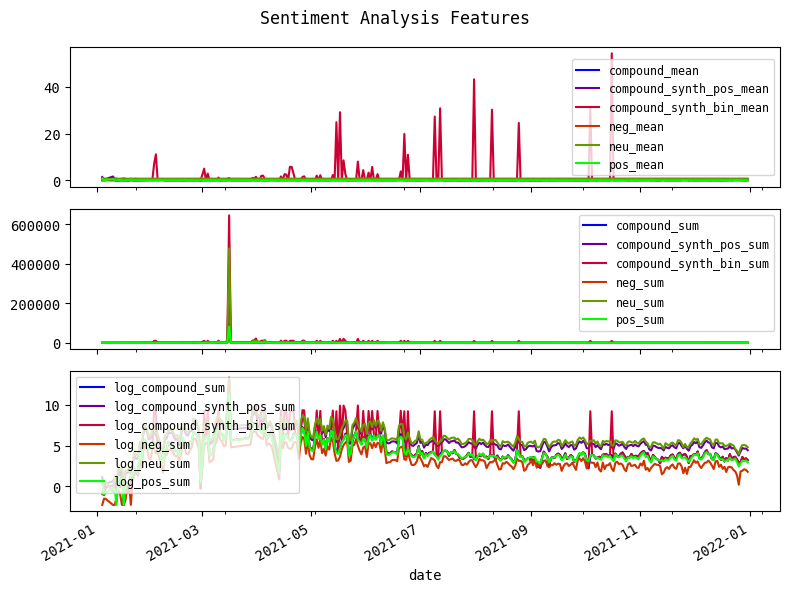

In [61]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

plt.suptitle('Sentiment Analysis Features')

reddit_agg.set_index('date').filter(regex='_mean').plot(cmap='brg', ax=axs[0])
reddit_agg.set_index('date').filter(regex='^(?!log).*sum').plot(cmap='brg', ax=axs[1])
reddit_agg.set_index('date').filter(regex='log_.+_sum').plot(cmap='brg', ax=axs[2])

axs[0].legend(fontsize='small')
axs[1].legend(fontsize='small')
axs[2].legend(fontsize='small')

plt.tight_layout()

plt.savefig(os.path.join(FIG_DIR, 'sentiment-analysis-feat.png'))
plt.show()